# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 2 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist())-1)
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


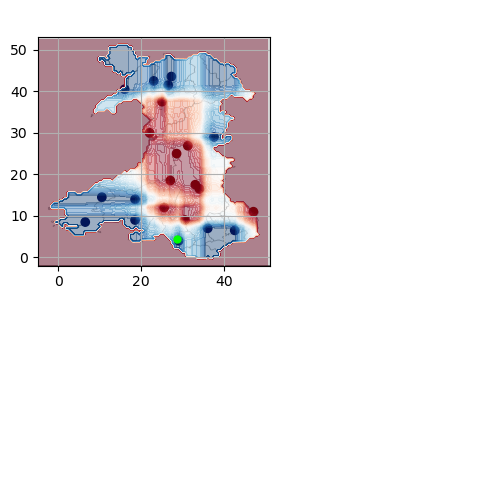

iteration  1
Accuracy is 0.4899057873485868
iteration  2
Accuracy is 0.48202268794462605
iteration  3
Accuracy is 0.6789079023264757
iteration  4
Accuracy is 0.7879253989617381
iteration  5
Accuracy is 0.787156316093059
iteration  6
Accuracy is 0.8384925975773889
iteration  7
Accuracy is 0.8521438184964429
iteration  8
Accuracy is 0.8146510286483368
iteration  9
Accuracy is 0.8244568352239954
iteration  10
Accuracy is 0.8323399346279562
iteration  11
Accuracy is 0.8559892328398385
iteration  12
Accuracy is 0.8094597192847529
iteration  13
Accuracy is 0.8384925975773889
iteration  14
Accuracy is 0.8252259180926745
iteration  15
Accuracy is 0.8506056527590848
iteration  16
Accuracy is 0.8384925975773889
iteration  17
Accuracy is 0.8544510671024803
iteration  18
Accuracy is 0.8650259565468179
iteration  19
Accuracy is 0.8756008459911555
iteration  20
Accuracy is 0.8750240338396462
iteration  21
Accuracy is 0.8719477023649298
experiment:  1


<IPython.core.display.Javascript object>


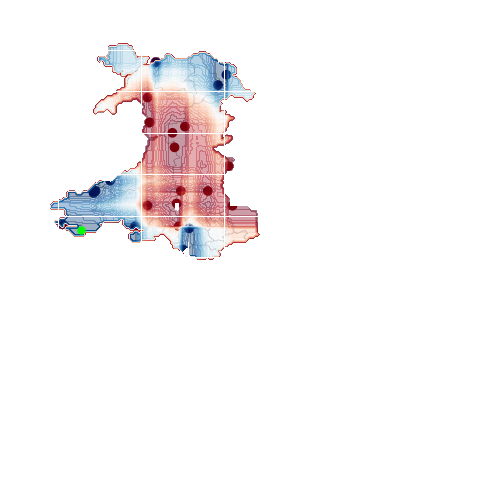

iteration  1
Accuracy is 0.48259950009613534
iteration  2
Accuracy is 0.5996923668525284
iteration  3
Accuracy is 0.5654681791963084
iteration  4
Accuracy is 0.45991155547010193
iteration  5
Accuracy is 0.5472024610651798
iteration  6
Accuracy is 0.5398961738127284
iteration  7
Accuracy is 0.7517785041338204
iteration  8
Accuracy is 0.7665833493558931
iteration  9
Accuracy is 0.7669678907902326
iteration  10
Accuracy is 0.7821572774466449
iteration  11
Accuracy is 0.7408190732551433
iteration  12
Accuracy is 0.7021726591040185
iteration  13
Accuracy is 0.7040953662757162
iteration  14
Accuracy is 0.7254374158815612
iteration  15
Accuracy is 0.6667948471447799
iteration  16
Accuracy is 0.6994808690636416
iteration  17
Accuracy is 0.7215920015381657
iteration  18
Accuracy is 0.7392809075177851
iteration  19
Accuracy is 0.7892712939819265
iteration  20
Accuracy is 0.7954239569313594
iteration  21
Accuracy is 0.7706210344164584
experiment:  2


<IPython.core.display.Javascript object>


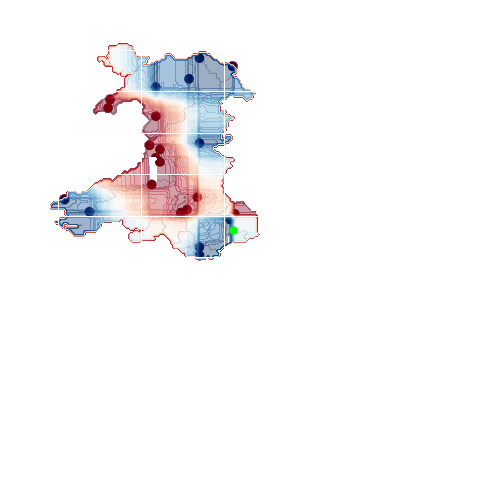

iteration  1
Accuracy is 0.48279177081330515
iteration  2
Accuracy is 0.671793885791194
iteration  3
Accuracy is 0.6573735820034609
iteration  4
Accuracy is 0.6264179965391271
iteration  5
Accuracy is 0.6569890405691213
iteration  6
Accuracy is 0.6533358969428956
iteration  7
Accuracy is 0.6842914824072294
iteration  8
Accuracy is 0.6617958084983657
iteration  9
Accuracy is 0.6900596039223227
iteration  10
Accuracy is 0.6529513555085561
iteration  11
Accuracy is 0.6773697365891175
iteration  12
Accuracy is 0.6806383387810037
iteration  13
Accuracy is 0.7223610844068449
iteration  14
Accuracy is 0.7090944049221304
iteration  15
Accuracy is 0.7356277638915593
iteration  16
Accuracy is 0.8096519900019227
iteration  17
Accuracy is 0.7908094597192847
iteration  18
Accuracy is 0.7977312055373966
iteration  19
Accuracy is 0.813689675062488
iteration  20
Accuracy is 0.804268409921169
iteration  21
Accuracy is 0.84618342626418
experiment:  3


<IPython.core.display.Javascript object>


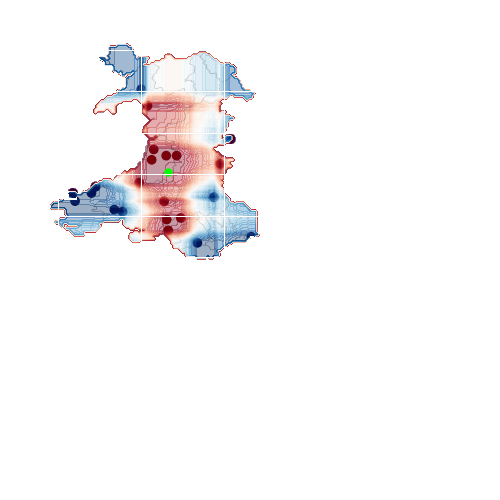

iteration  1
Accuracy is 0.5293212843683907
iteration  2
Accuracy is 0.6867910017304365
iteration  3
Accuracy is 0.6579503941549703
iteration  4
Accuracy is 0.6181503557008268
iteration  5
Accuracy is 0.6135358584887521
iteration  6
Accuracy is 0.6519900019227072
iteration  7
Accuracy is 0.6281484329936551
iteration  8
Accuracy is 0.6344933666602577
iteration  9
Accuracy is 0.788886752547587
iteration  10
Accuracy is 0.7529321284368391
iteration  11
Accuracy is 0.7692751393962699
iteration  12
Accuracy is 0.7496635262449529
iteration  13
Accuracy is 0.5929628917515862
iteration  14
Accuracy is 0.6260334551047876
iteration  15
Accuracy is 0.6077677369736589
iteration  16
Accuracy is 0.7288982887906172
iteration  17
Accuracy is 0.7371659296289175
iteration  18
Accuracy is 0.7135166314170351
iteration  19
Accuracy is 0.7192847529321285
iteration  20
Accuracy is 0.7112093828109979
iteration  21
Accuracy is 0.7635070178811767
experiment:  4


<IPython.core.display.Javascript object>


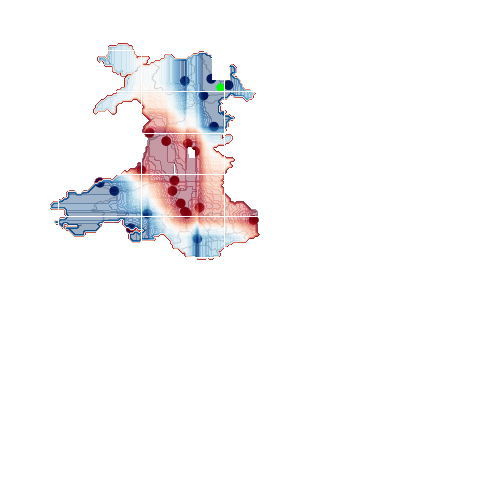

iteration  1
Accuracy is 0.6004614497212074
iteration  2
Accuracy is 0.49663526244952894
iteration  3
Accuracy is 0.49740434531820804
iteration  4
Accuracy is 0.49125168236877526
iteration  5
Accuracy is 0.6033455104787541
iteration  6
Accuracy is 0.71793885791194
iteration  7
Accuracy is 0.7363968467602384
iteration  8
Accuracy is 0.8027302441838108
iteration  9
Accuracy is 0.8127283214766391
iteration  10
Accuracy is 0.792347625456643
iteration  11
Accuracy is 0.8557969621226688
iteration  12
Accuracy is 0.8252259180926745
iteration  13
Accuracy is 0.8484906748702172
iteration  14
Accuracy is 0.8377235147087099
iteration  15
Accuracy is 0.8054220342241877
iteration  16
Accuracy is 0.8127283214766391
iteration  17
Accuracy is 0.8396462218804076
iteration  18
Accuracy is 0.8634877908094597
iteration  19
Accuracy is 0.8534897135166314
iteration  20
Accuracy is 0.8754085752739857
iteration  21
Accuracy is 0.8684868294558739
experiment:  5


<IPython.core.display.Javascript object>


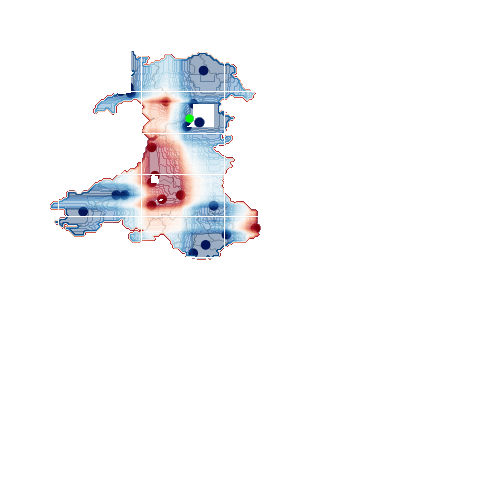

iteration  1
Accuracy is 0.4681791963084022
iteration  2
Accuracy is 0.506825610459527
iteration  3
Accuracy is 0.5608536819842338
iteration  4
Accuracy is 0.5004806767929244
iteration  5
Accuracy is 0.5229763507017882
iteration  6
Accuracy is 0.5283599307825418
iteration  7
Accuracy is 0.606037300519131
iteration  8
Accuracy is 0.6010382618727168
iteration  9
Accuracy is 0.6269948086906364
iteration  10
Accuracy is 0.5939242453374352
iteration  11
Accuracy is 0.6429532782157278
iteration  12
Accuracy is 0.6291097865795039
iteration  13
Accuracy is 0.634108825225918
iteration  14
Accuracy is 0.6814074216496827
iteration  15
Accuracy is 0.6604499134781773
iteration  16
Accuracy is 0.679484714477985
iteration  17
Accuracy is 0.6704479907710056
iteration  18
Accuracy is 0.789655835416266
iteration  19
Accuracy is 0.8231109402038069
iteration  20
Accuracy is 0.8311863103249375
iteration  21
Accuracy is 0.840992116900596
experiment:  6


<IPython.core.display.Javascript object>


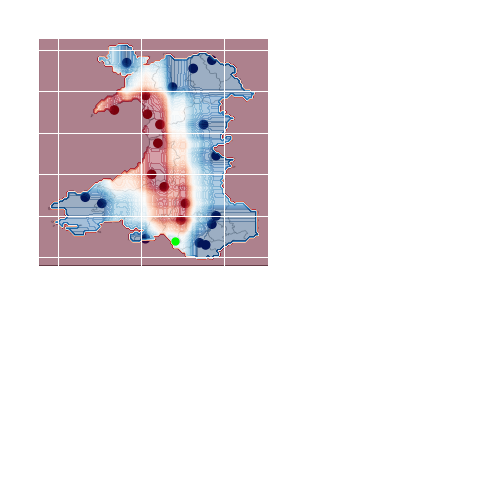

iteration  1
Accuracy is 0.4922130359546241
iteration  2
Accuracy is 0.7954239569313594
iteration  3
Accuracy is 0.6858296481445876
iteration  4
Accuracy is 0.7260142280330706
iteration  5
Accuracy is 0.6865987310132666
iteration  6
Accuracy is 0.6814074216496827
iteration  7
Accuracy is 0.6637185156700635
iteration  8
Accuracy is 0.6639107863872332
iteration  9
Accuracy is 0.689675062487983
iteration  10
Accuracy is 0.8011920784464526
iteration  11
Accuracy is 0.8140742164968275
iteration  12
Accuracy is 0.8173428186887137
iteration  13
Accuracy is 0.8177273601230532
iteration  14
Accuracy is 0.8365698904056912
iteration  15
Accuracy is 0.8411843876177658
iteration  16
Accuracy is 0.827340895981542
iteration  17
Accuracy is 0.8386848682945588
iteration  18
Accuracy is 0.860603730051913
iteration  19
Accuracy is 0.8584887521630455
iteration  20
Accuracy is 0.8454143433955008
iteration  21
Accuracy is 0.8336858296481446
experiment:  7


<IPython.core.display.Javascript object>


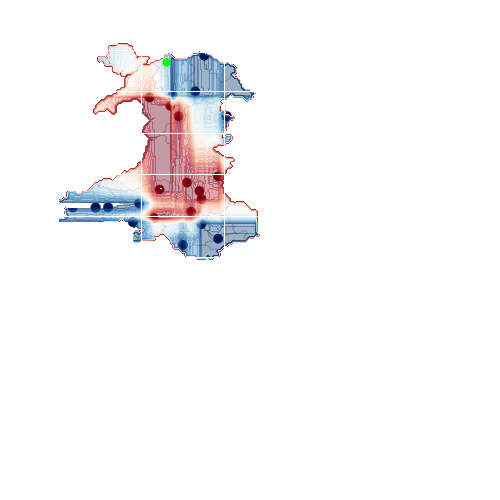

iteration  1
Accuracy is 0.5998846375696981
iteration  2
Accuracy is 0.5241299750048067
iteration  3
Accuracy is 0.7071716977504326
iteration  4
Accuracy is 0.7396654489521246
iteration  5
Accuracy is 0.7733128244568352
iteration  6
Accuracy is 0.729090559507787
iteration  7
Accuracy is 0.7533166698711786
iteration  8
Accuracy is 0.7513939626994809
iteration  9
Accuracy is 0.7635070178811767
iteration  10
Accuracy is 0.687175543164776
iteration  11
Accuracy is 0.6758315708517593
iteration  12
Accuracy is 0.7075562391847722
iteration  13
Accuracy is 0.733320515285522
iteration  14
Accuracy is 0.8096519900019227
iteration  15
Accuracy is 0.7831186310324938
iteration  16
Accuracy is 0.7531243991540089
iteration  17
Accuracy is 0.7967698519515478
iteration  18
Accuracy is 0.7704287636992886
iteration  19
Accuracy is 0.8277254374158816
iteration  20
Accuracy is 0.8421457412036147
iteration  21
Accuracy is 0.8281099788502211
experiment:  8


<IPython.core.display.Javascript object>


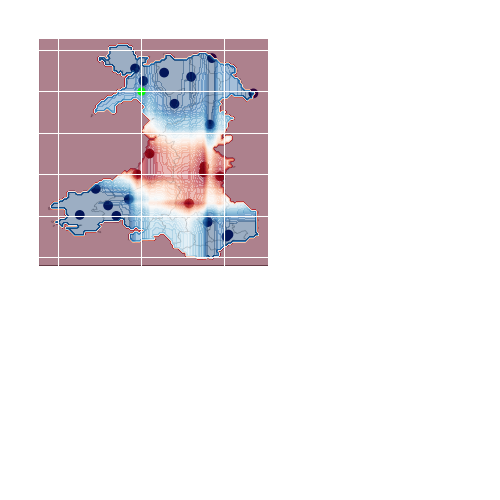

iteration  1
Accuracy is 0.5562391847721592
iteration  2
Accuracy is 0.5070178811766968
iteration  3
Accuracy is 0.5279753893482023
iteration  4
Accuracy is 0.6502595654681792
iteration  5
Accuracy is 0.5893097481253605
iteration  6
Accuracy is 0.6416073831955393
iteration  7
Accuracy is 0.6337242837915785
iteration  8
Accuracy is 0.7363968467602384
iteration  9
Accuracy is 0.7229378965583542
iteration  10
Accuracy is 0.7312055373966545
iteration  11
Accuracy is 0.7446644875985388
iteration  12
Accuracy is 0.7244760622957124
iteration  13
Accuracy is 0.7256296865987311
iteration  14
Accuracy is 0.731590078830994
iteration  15
Accuracy is 0.7852336089213613
iteration  16
Accuracy is 0.798308017688906
iteration  17
Accuracy is 0.7886944818304172
iteration  18
Accuracy is 0.779465487406268
iteration  19
Accuracy is 0.7773505095174005
iteration  20
Accuracy is 0.788117669678908
iteration  21
Accuracy is 0.804268409921169
experiment:  9


<IPython.core.display.Javascript object>


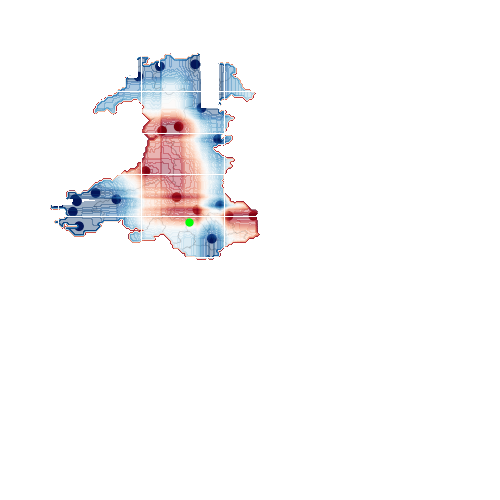

iteration  1
Accuracy is 0.5756585272063065
iteration  2
Accuracy is 0.6243030186502596
iteration  3
Accuracy is 0.5983464718323399
iteration  4
Accuracy is 0.6987117861949625
iteration  5
Accuracy is 0.7638915593155162
iteration  6
Accuracy is 0.6796769851951547
iteration  7
Accuracy is 0.6925591232455297
iteration  8
Accuracy is 0.7131320899826956
iteration  9
Accuracy is 0.7296673716592963
iteration  10
Accuracy is 0.7460103826187272
iteration  11
Accuracy is 0.7525475870024996
iteration  12
Accuracy is 0.7850413382041915
iteration  13
Accuracy is 0.7688905979619304
iteration  14
Accuracy is 0.7844645260526821
iteration  15
Accuracy is 0.790617189002115
iteration  16
Accuracy is 0.7731205537396655
iteration  17
Accuracy is 0.7744664487598538
iteration  18
Accuracy is 0.8640646029609691
iteration  19
Accuracy is 0.8450298019611613
iteration  20
Accuracy is 0.8571428571428571
iteration  21
Accuracy is 0.8663718515670064
experiment:  10


<IPython.core.display.Javascript object>


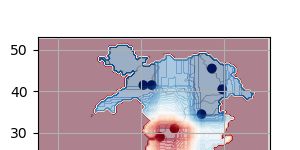

iteration  1
Accuracy is 0.5004806767929244
iteration  2
Accuracy is 0.58123437800423
iteration  3
Accuracy is 0.5372043837723515
iteration  4
Accuracy is 0.5864256873678139
iteration  5
Accuracy is 0.5733512786002691
iteration  6
Accuracy is 0.5710440299942319
iteration  7
Accuracy is 0.5646990963276293
iteration  8
Accuracy is 0.7227456258411844
iteration  9
Accuracy is 0.6923668525283599
iteration  10
Accuracy is 0.7644683714670256
iteration  11
Accuracy is 0.7515862334166507
iteration  12
Accuracy is 0.7667756200730629
iteration  13
Accuracy is 0.7669678907902326
iteration  14
Accuracy is 0.721399730820996
iteration  15
Accuracy is 0.7381272832147664
iteration  16
Accuracy is 0.7496635262449529
iteration  17
Accuracy is 0.8173428186887137
iteration  18
Accuracy is 0.8319553931936167
iteration  19
Accuracy is 0.8488752163045569
iteration  20
Accuracy is 0.8254181888098443
iteration  21
Accuracy is 0.8083060949817343
experiment:  11


<IPython.core.display.Javascript object>


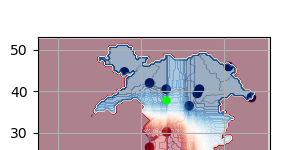

iteration  1
Accuracy is 0.5616227648529128
iteration  2
Accuracy is 0.6666025764276101
iteration  3
Accuracy is 0.6058450298019612
iteration  4
Accuracy is 0.6958277254374159
iteration  5
Accuracy is 0.7858104210728706
iteration  6
Accuracy is 0.7231301672755239
iteration  7
Accuracy is 0.7296673716592963
iteration  8
Accuracy is 0.7329359738511825
iteration  9
Accuracy is 0.7562007306287253
iteration  10
Accuracy is 0.7710055758507979
iteration  11
Accuracy is 0.7819650067294751
iteration  12
Accuracy is 0.7785041338204192
iteration  13
Accuracy is 0.7729282830224957
iteration  14
Accuracy is 0.7565852720630648
iteration  15
Accuracy is 0.7785041338204192
iteration  16
Accuracy is 0.7960007690828687
iteration  17
Accuracy is 0.7829263603153239
iteration  18
Accuracy is 0.781195923860796
iteration  19
Accuracy is 0.7894635646990963
iteration  20
Accuracy is 0.781195923860796
iteration  21
Accuracy is 0.7758123437800423
experiment:  12


<IPython.core.display.Javascript object>


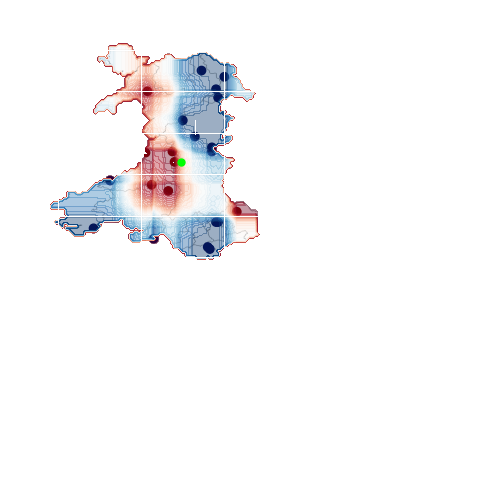

iteration  1
Accuracy is 0.6019996154585656
iteration  2
Accuracy is 0.5754662564891367
iteration  3
Accuracy is 0.5729667371659296
iteration  4
Accuracy is 0.7231301672755239
iteration  5
Accuracy is 0.7394731782349548
iteration  6
Accuracy is 0.7160161507402423
iteration  7
Accuracy is 0.7200538358008075
iteration  8
Accuracy is 0.7600461449721208
iteration  9
Accuracy is 0.7579311670832533
iteration  10
Accuracy is 0.7517785041338204
iteration  11
Accuracy is 0.7613920399923092
iteration  12
Accuracy is 0.7387040953662757
iteration  13
Accuracy is 0.8040761392039992
iteration  14
Accuracy is 0.8242645645068256
iteration  15
Accuracy is 0.8050374927898482
iteration  16
Accuracy is 0.746202653335897
iteration  17
Accuracy is 0.7585079792347625
iteration  18
Accuracy is 0.7677369736589118
iteration  19
Accuracy is 0.7490867140934435
iteration  20
Accuracy is 0.7521630455681599
iteration  21
Accuracy is 0.764083830032686
experiment:  13


<IPython.core.display.Javascript object>


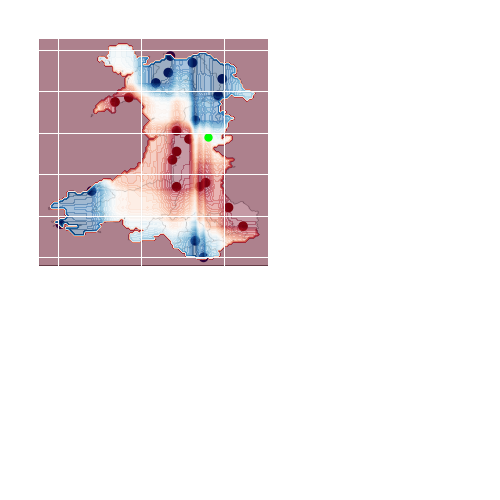

iteration  1
Accuracy is 0.6091136319938474
iteration  2
Accuracy is 0.4762545664295328
iteration  3
Accuracy is 0.5064410690251875
iteration  4
Accuracy is 0.6533358969428956
iteration  5
Accuracy is 0.5877715823880023
iteration  6
Accuracy is 0.6475677754278023
iteration  7
Accuracy is 0.6610267256296866
iteration  8
Accuracy is 0.7538934820226879
iteration  9
Accuracy is 0.6621803499327052
iteration  10
Accuracy is 0.6852528359930783
iteration  11
Accuracy is 0.6977504326091136
iteration  12
Accuracy is 0.7654297250528744
iteration  13
Accuracy is 0.8108056143049414
iteration  14
Accuracy is 0.8233032109209767
iteration  15
Accuracy is 0.8084983656989041
iteration  16
Accuracy is 0.800807537012113
iteration  17
Accuracy is 0.8256104595270141
iteration  18
Accuracy is 0.8163814651028648
iteration  19
Accuracy is 0.8040761392039992
iteration  20
Accuracy is 0.7921553547394732
iteration  21
Accuracy is 0.7948471447798501
experiment:  14


<IPython.core.display.Javascript object>


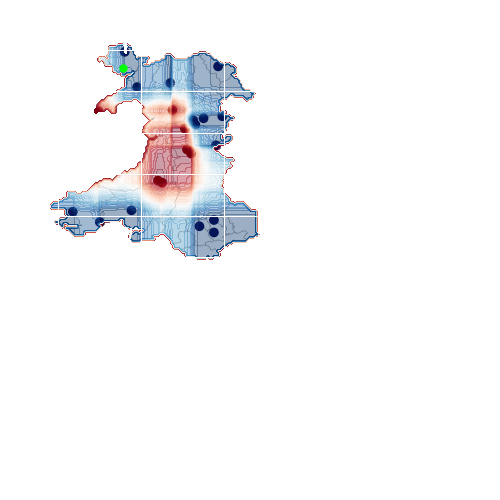

iteration  1
Accuracy is 0.3730051913093636
iteration  2
Accuracy is 0.5479715439338588
iteration  3
Accuracy is 0.6035377811959238
iteration  4
Accuracy is 0.7335127860026918
iteration  5
Accuracy is 0.761584310709479
iteration  6
Accuracy is 0.7304364545279753
iteration  7
Accuracy is 0.7385118246491059
iteration  8
Accuracy is 0.7181311286291098
iteration  9
Accuracy is 0.7725437415881561
iteration  10
Accuracy is 0.813689675062488
iteration  11
Accuracy is 0.7773505095174005
iteration  12
Accuracy is 0.8167660065372044
iteration  13
Accuracy is 0.8006152662949433
iteration  14
Accuracy is 0.8246491059411651
iteration  15
Accuracy is 0.8104210728706018
iteration  16
Accuracy is 0.8227263987694674
iteration  17
Accuracy is 0.7813881945779658
iteration  18
Accuracy is 0.8329167467794655
iteration  19
Accuracy is 0.8283022495673908
iteration  20
Accuracy is 0.8173428186887137
iteration  21
Accuracy is 0.8188809844260719
experiment:  15


<IPython.core.display.Javascript object>


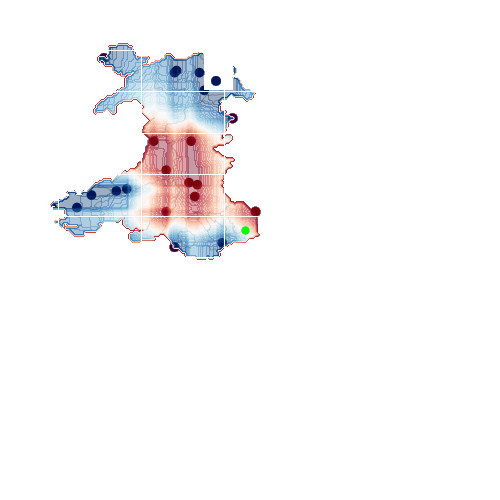

iteration  1
Accuracy is 0.5439338588732936
iteration  2
Accuracy is 0.6131513170544126
iteration  3
Accuracy is 0.6940972889828879
iteration  4
Accuracy is 0.7677369736589118
iteration  5
Accuracy is 0.7800422995577774
iteration  6
Accuracy is 0.7825418188809844
iteration  7
Accuracy is 0.77773505095174
iteration  8
Accuracy is 0.7723514708709863
iteration  9
Accuracy is 0.7567775427802346
iteration  10
Accuracy is 0.787156316093059
iteration  11
Accuracy is 0.8069601999615459
iteration  12
Accuracy is 0.8079215535473947
iteration  13
Accuracy is 0.8169582772543742
iteration  14
Accuracy is 0.7942703326283407
iteration  15
Accuracy is 0.8309940396077677
iteration  16
Accuracy is 0.8496442991732359
iteration  17
Accuracy is 0.8779080945971929
iteration  18
Accuracy is 0.859834647183234
iteration  19
Accuracy is 0.8631032493751202
iteration  20
Accuracy is 0.8644491443953086
iteration  21
Accuracy is 0.8425302826379543
experiment:  16


<IPython.core.display.Javascript object>


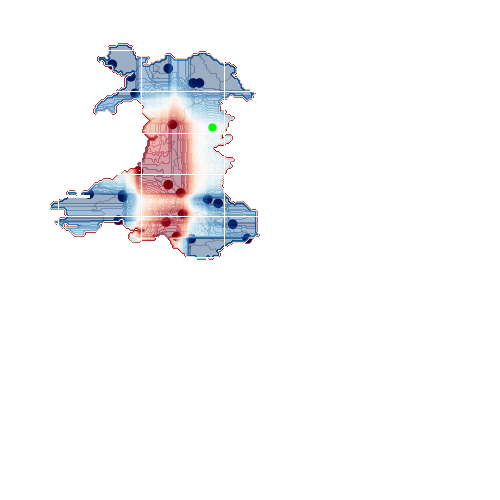

iteration  1
Accuracy is 0.5260526821765045
iteration  2
Accuracy is 0.4983656989040569
iteration  3
Accuracy is 0.505095174004999
iteration  4
Accuracy is 0.5320130744087676
iteration  5
Accuracy is 0.5135550855604691
iteration  6
Accuracy is 0.5385502787925399
iteration  7
Accuracy is 0.8083060949817343
iteration  8
Accuracy is 0.8857911940011536
iteration  9
Accuracy is 0.8411843876177658
iteration  10
Accuracy is 0.8296481445875793
iteration  11
Accuracy is 0.8038838684868295
iteration  12
Accuracy is 0.8027302441838108
iteration  13
Accuracy is 0.7919630840223034
iteration  14
Accuracy is 0.7786964045375889
iteration  15
Accuracy is 0.8106133435877716
iteration  16
Accuracy is 0.8031147856181503
iteration  17
Accuracy is 0.8102288021534321
iteration  18
Accuracy is 0.8138819457796578
iteration  19
Accuracy is 0.8198423380119207
iteration  20
Accuracy is 0.8175350894058835
iteration  21
Accuracy is 0.8215727744664487
experiment:  17


<IPython.core.display.Javascript object>


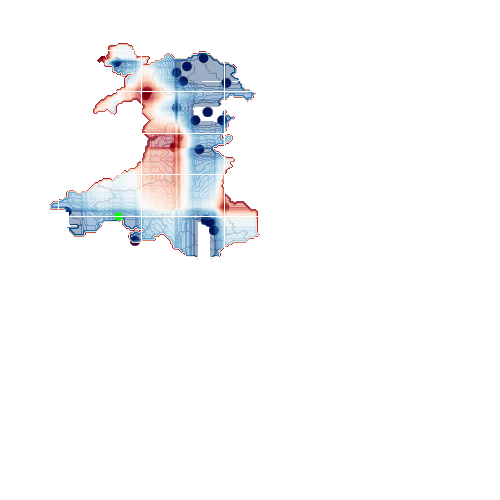

iteration  1
Accuracy is 0.5668140742164969
iteration  2
Accuracy is 0.5877715823880023
iteration  3
Accuracy is 0.5766198807921553
iteration  4
Accuracy is 0.5748894443376273
iteration  5
Accuracy is 0.5758507979234763
iteration  6
Accuracy is 0.5846952509132859
iteration  7
Accuracy is 0.5902711017112093
iteration  8
Accuracy is 0.566621803499327
iteration  9
Accuracy is 0.6056527590847914
iteration  10
Accuracy is 0.6106517977312056
iteration  11
Accuracy is 0.6041145933474332
iteration  12
Accuracy is 0.6016150740242261
iteration  13
Accuracy is 0.6048836762161123
iteration  14
Accuracy is 0.6990963276293021
iteration  15
Accuracy is 0.7140934435685445
iteration  16
Accuracy is 0.6944818304172274
iteration  17
Accuracy is 0.7012113055181696
iteration  18
Accuracy is 0.719669294366468
iteration  19
Accuracy is 0.7886944818304172
iteration  20
Accuracy is 0.8013843491636223
iteration  21
Accuracy is 0.8011920784464526
experiment:  18


<IPython.core.display.Javascript object>


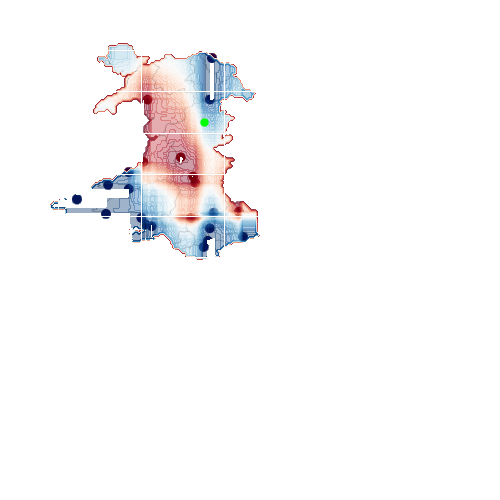

iteration  1
Accuracy is 0.4776004614497212
iteration  2
Accuracy is 0.5875793116708325
iteration  3
Accuracy is 0.744472216881369
iteration  4
Accuracy is 0.7027494712555278
iteration  5
Accuracy is 0.7406268025379734
iteration  6
Accuracy is 0.7808113824264564
iteration  7
Accuracy is 0.7542780234570275
iteration  8
Accuracy is 0.7579311670832533
iteration  9
Accuracy is 0.6710248029225149
iteration  10
Accuracy is 0.665833493558931
iteration  11
Accuracy is 0.6660257642761007
iteration  12
Accuracy is 0.6746779465487406
iteration  13
Accuracy is 0.694866371851567
iteration  14
Accuracy is 0.694866371851567
iteration  15
Accuracy is 0.6944818304172274
iteration  16
Accuracy is 0.7352432224572197
iteration  17
Accuracy is 0.7310132666794847
iteration  18
Accuracy is 0.7313978081138243
iteration  19
Accuracy is 0.7379350124975966
iteration  20
Accuracy is 0.77773505095174
iteration  21
Accuracy is 0.7742741780426841
experiment:  19


<IPython.core.display.Javascript object>


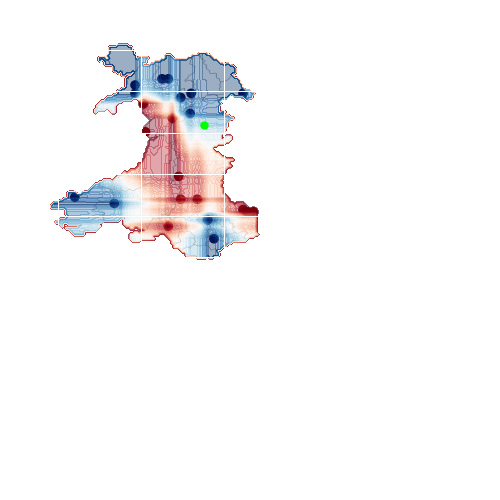

iteration  1
Accuracy is 0.5975773889636609
iteration  2
Accuracy is 0.5858488752163046
iteration  3
Accuracy is 0.6091136319938474
iteration  4
Accuracy is 0.6396846760238416
iteration  5
Accuracy is 0.6408383003268602
iteration  6
Accuracy is 0.827340895981542
iteration  7
Accuracy is 0.8190732551432417
iteration  8
Accuracy is 0.7919630840223034
iteration  9
Accuracy is 0.7942703326283407
iteration  10
Accuracy is 0.8284945202845606
iteration  11
Accuracy is 0.8654104979811574
iteration  12
Accuracy is 0.8321476639107864
iteration  13
Accuracy is 0.8577196692943665
iteration  14
Accuracy is 0.8392616804460681
iteration  15
Accuracy is 0.8575273985771967
iteration  16
Accuracy is 0.875216304556816
iteration  17
Accuracy is 0.8557969621226688
iteration  18
Accuracy is 0.8775235531628532
iteration  19
Accuracy is 0.8746394924053067
iteration  20
Accuracy is 0.8811766967890791
iteration  21
Accuracy is 0.8819457796577581
experiment:  20


<IPython.core.display.Javascript object>


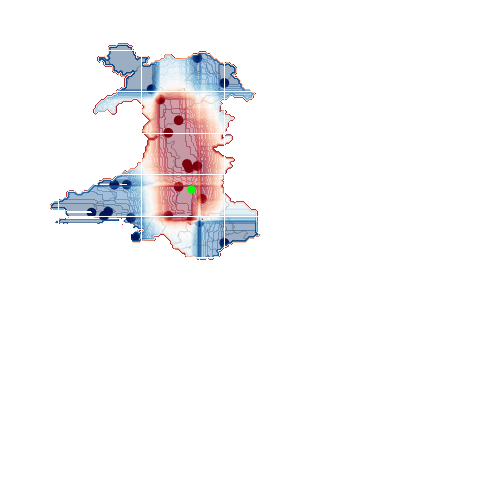

iteration  1
Accuracy is 0.5322053451259373
iteration  2
Accuracy is 0.4858681022880215
iteration  3
Accuracy is 0.5081715054797155
iteration  4
Accuracy is 0.5500865218227264
iteration  5
Accuracy is 0.5250913285906557
iteration  6
Accuracy is 0.5402807152470679
iteration  7
Accuracy is 0.6410305710440299
iteration  8
Accuracy is 0.6479523168621419
iteration  9
Accuracy is 0.6144972120746011
iteration  10
Accuracy is 0.5983464718323399
iteration  11
Accuracy is 0.7235147087098635
iteration  12
Accuracy is 0.7506248798308017
iteration  13
Accuracy is 0.7771582388002307
iteration  14
Accuracy is 0.7650451836185349
iteration  15
Accuracy is 0.7627379350124976
iteration  16
Accuracy is 0.78638723322438
iteration  17
Accuracy is 0.7579311670832533
iteration  18
Accuracy is 0.7660065372043837
iteration  19
Accuracy is 0.7748509901941935
iteration  20
Accuracy is 0.773505095174005
iteration  21
Accuracy is 0.7861949625072101


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 78.64 %
Improvement is = 25.42 %


In [9]:
Results

[[0.4899057873485868,
  0.48202268794462605,
  0.6789079023264757,
  0.7879253989617381,
  0.787156316093059,
  0.8384925975773889,
  0.8521438184964429,
  0.8146510286483368,
  0.8244568352239954,
  0.8323399346279562,
  0.8559892328398385,
  0.8094597192847529,
  0.8384925975773889,
  0.8252259180926745,
  0.8506056527590848,
  0.8384925975773889,
  0.8544510671024803,
  0.8650259565468179,
  0.8756008459911555,
  0.8750240338396462,
  0.8719477023649298],
 [0.48259950009613534,
  0.5996923668525284,
  0.5654681791963084,
  0.45991155547010193,
  0.5472024610651798,
  0.5398961738127284,
  0.7517785041338204,
  0.7665833493558931,
  0.7669678907902326,
  0.7821572774466449,
  0.7408190732551433,
  0.7021726591040185,
  0.7040953662757162,
  0.7254374158815612,
  0.6667948471447799,
  0.6994808690636416,
  0.7215920015381657,
  0.7392809075177851,
  0.7892712939819265,
  0.7954239569313594,
  0.7706210344164584],
 [0.48279177081330515,
  0.671793885791194,
  0.6573735820034609,
  0.62

In [10]:
np.savetxt('BraninRandompls', Results)

In [11]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))

for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)

NameError: name 'tst' is not defined

In [ ]:
tst = np.loadtxt('BraninRandom')